**Convolutional Neural Networks**

**DEEP LEARNING DOG BREED CLASSIFIER**

## Step 1:**Import the dog and human datasets**

In [36]:
import requests, zipfile, io, os, shutil

root = '/content'
dogimages_url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"
humanimages_url = "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip"

data_path = os.path.join(root,'data')
dogimages_path = os.path.join(data_path,'dogImages')
humanimages_path = os.path.join(data_path,'lfw')
data_path = os.path.join(root,'data')
if not os.path.exists(data_path): os.mkdir(data_path)


if not os.path.exists(dogimages_path):
  print("downloading dog images")
  r = requests.get(dogimages_url) 
  z = zipfile.ZipFile(io.BytesIO(r.content)) 
  z.extractall(data_path)

if not os.path.exists(humanimages_path):
  print("downloading human images")
  r = requests.get(humanimages_url) 
  z = zipfile.ZipFile(io.BytesIO(r.content)) 
  z.extractall(data_path)

import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/content/data/lfw/*/*"))
dog_files = np.array(glob("/content/data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


#Step 2: **Detect Humans**

Number of faces detected: 1


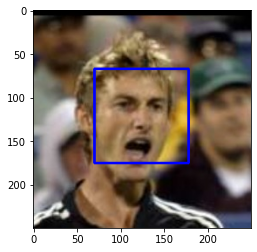

In [8]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               


# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# load color (BGR) image
img = cv2.imread(human_files[1])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Step 2.0: **Human face detectcor**

In [9]:
# returns "True" if face is detected in image stored at img_path
def haar_face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Step 2.1: **Assess the human face detector**

In [34]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Here we do test the performance of the face detector algorithm

human_files_count=0
dog_files_count=0
for i in range(len(human_files_short)):
    if haar_face_detector(human_files_short[i]):
        human_files_count+=1
    if haar_face_detector(dog_files_short[i]):
        dog_files_count+=1
print("number of human faces detected in human_fiiles_hort {0}".format(human_files_count))
print("number of human faces detected in dog_files_short {0}".format(dog_files_count))


number of human faces detected in human_fiiles_hort 100
number of human faces detected in dog_files_short 41


# Step 3: ***Detect dogs***

Step 3.0: **Obtain the pretrained VGG-16 Model**

In [12]:
import torch
import torchvision.models as models

# defining VGG16 model
VGG16 = models.vgg16(pretrained=True)

# checking if CUDA is available
use_cuda = torch.cuda.is_available()

# moving the model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Step 3.1: **Making predictions with pretrained model**

In [13]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import os

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # data transformation
    batch_size = 64
    img = Image.open(img_path).convert('RGB')
    image_transforms = transforms.Compose([
                            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                            transforms.RandomRotation(degrees=15),
                            transforms.ColorJitter(),
                            transforms.RandomHorizontalFlip(),
                            transforms.CenterCrop(size=224),  # Image net standards
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406],
                                                 [0.229, 0.224, 0.225])  # Imagenet standards
                        ])
    
    image = image_transforms(img)[:3,:,:].unsqueeze(0)
#     image = image_transforms(img)
#     print(image_transformation)
    
    if use_cuda:
        image = image.cuda()
    output = VGG16(image)

    _,pred = torch.max(output, dim=1)
    pred=pred.cpu()
    pred = pred.data.numpy()[0]
        
    return pred # predicted class index

VGG16_predict(dog_files[0])

156

Step 3.2: **Dog Detector**

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
#     in VGG16 index 151 to 268 are dog classifications
    
    return VGG16_predict(img_path)>= 151 and VGG16_predict(img_path)<=268 # true/false
print(dog_detector(human_files[3]))
print(dog_detector(dog_files[7]))

False
True


Step 3.3: **Assess the Dog Detector**

In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_count=0
dog_files_count=0
for i in range(len(human_files_short)):
    if dog_detector(human_files_short[i]):
        human_files_count+=1
    if dog_detector(dog_files_short[i]):
        dog_files_count+=1
print("number of dog faces detected in human_fiiles_short {0}".format(human_files_count))
print("number of dog faces detected in dog_files_short {0}".format(dog_files_count))


number of dog faces detected in human_fiiles_short 4
number of dog faces detected in dog_files_short 99


# Step 4: ***Creating a CNN to Classify Dog Breeds without transfer learning***

Step 4.0: **Specify data loaders for dog dataset**

In [16]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '/content/data/dogImages/train/'
val_path = '/content/data/dogImages/valid'
test_path = '/content/data/dogImages/test'

batch_size=64
train_generator = train_datagen.flow_from_directory(
        train_path,
        # '/content/cats_dogs/data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory(
        val_path,
        # '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
        test_path,
        # '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')



Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 836 images belonging to 133 classes.


Step 4.1: **Create the CNN**

In [18]:
from time import time
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=( 150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(133))
model.add(Activation('softmax'))

Step 4.2: **Specify Loss function and Optimizer**

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Step 4.3: **Train and validate model**

In [20]:
start_time = time()
model.fit_generator(
        train_generator,
        #steps_per_epoch=18631 // batch_size,
        epochs=16,
        validation_data=validation_generator,
        #validation_steps=10119 // batch_size
        )
model.save_weights('first_try.h5')

print('time taken ',time()-start_time)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/16
105/105 [==============================] - 89s 812ms/step - loss: 4.8996 - accuracy: 0.0094 - val_loss: 4.8737 - val_accuracy: 0.0168
Epoch 2/16
105/105 [==============================] - 84s 799ms/step - loss: 4.8127 - accuracy: 0.0178 - val_loss: 4.7026 - val_accuracy: 0.0275
Epoch 3/16
105/105 [==============================] - 86s 824ms/step - loss: 4.5946 - accuracy: 0.0328 - val_loss: 4.4875 - val_accuracy: 0.0431
Epoch 4/16
105/105 [==============================] - 81s 772ms/step - loss: 4.3870 - accuracy: 0.0524 - val_loss: 4.3118 - val_accuracy: 0.0599
Epoch 5/16
105/105 [==============================] - 86s 818ms/step - loss: 4.2151 - accuracy: 0.0675 - val_loss: 4.2897 - val_accuracy: 0.0659
Epoch 6/16
105/105 [==============================] - 82s 781ms/step - loss: 4.1027 - accuracy: 0.0855 - val_loss: 4.2095 - val_accuracy: 0.0754
Epoch 7/16
105/105 [==============================] - 82s 782ms/step - loss: 3.9824 - accuracy: 0.0978 - val_loss: 4.2635 - val_ac

Step 4.4: **Test our model**

In [21]:
model.metrics_names

['loss', 'accuracy']

In [22]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_eval = model.evaluate_generator(test_generator,STEP_SIZE_TEST)
print('test loss ',test_eval[0])
print('test accuracy ',test_eval[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


test loss  4.144160747528076
test accuracy  0.12259615212678909


# Step 5: **Create a CNN model to classify Dog Breeds Using Transfer Learning**

Step 5.0: **Specify data loaders for dog dataset**

In [23]:
## Here we Specify data loaders
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '/content/data/dogImages/train/'
val_path = '/content/data/dogImages/valid'
test_path = '/content/data/dogImages/test'

batch_size=64
train_generator = train_datagen.flow_from_directory(
        train_path,
        # '/content/cats_dogs/data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory(
        val_path,
        # '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
        test_path,
        # '/content/cats_dogs/data/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 836 images belonging to 133 classes.


Step 5.1: **The Architecture of our model**

In [25]:
from time import time
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
import keras
keras.backend.set_learning_phase(1)

img_rows, img_cols, img_channel = 150, 150, 3
base_model = PTModel(weights='imagenet'
                     ,include_top=False, input_shape=(img_rows, img_cols, img_channel), classes = 2)
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(64, activation='relu'))
add_model.add(Dense(133, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

for layer in base_model.layers:
    layer.trainable = False

    if layer.name.startswith('bn'):
        layer.call(layer.input, training=False)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


58900480/58889256 [==============================] - 0s 0us/step


Step 5.2:  **Specify Loss function and Optimizer**

In [26]:
model.compile(loss='binary_crossentropy', 
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Step 5.3: **Train and Validate the model**

In [27]:
check_point_name = 'vgg16.model'
model_weights = 'vgg16.h5'

start_time = time()
model.fit_generator(
        train_generator,
        epochs=2,
        validation_data=validation_generator,
        #class_weight = class_weights,
        callbacks=[ModelCheckpoint(check_point_name, monitor='val_acc', save_best_only=True)])
model.save_weights(model_weights)

print('time taken ',time()-start_time)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/2
105/105 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.0087

105/105 [==============================] - 88s 800ms/step - loss: 0.6691 - accuracy: 0.0087 - val_loss: 0.6287 - val_accuracy: 0.0084
Epoch 2/2
105/105 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.0087

105/105 [==============================] - 83s 793ms/step - loss: 0.6105 - accuracy: 0.0087 - val_loss: 0.5966 - val_accuracy: 0.0072
time taken  230.43853521347046


Step 5.4: **Test the model**

In [28]:

test_generator.reset()
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_eval = model.evaluate_generator(test_generator,STEP_SIZE_TEST)
print('test loss ',test_eval[0])
print('test accuracy ',test_eval[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


test loss  0.5967719554901123
test accuracy  0.008413461968302727


Step 5.5: **Predict the Dog breed using the model build**

In [29]:
### The function below is to take image path as the input, process and produce the dog breed predicted by the model
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

def predict_breed_transfer(img_path):
    # Here we do load the image and later output the predicted breed of that image
  image = load(img_path)
  y_prob = model.predict(image)
  y_class = y_prob.argmax(axis=-1)
  # print(y_classes)
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  prediction = [labels[k] for k in y_class]
  return prediction    

Step 6: **Creating an Algorithm**

*This algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither. Then,*

if a dog is detected in the image, return the predicted breed.
if a human is detected in the image, return the resembling dog breed.
if neither is detected in the image, provide output that indicates an error.

In [30]:

def run_app(img_path):
    ## here we do handle the human face, dog, and neither cases
    if haar_face_detector(img_path):
      print('hello human')
      prediction = predict_breed_transfer(img_path)
      print(prediction)
    elif dog_detector(img_path):
      print('hello dog')
      prediction = predict_breed_transfer(img_path)
      print(prediction)
    else:
      print("Could not detect dog or human image")



# Step 7: **Testing our Developed Algorithm**

In [32]:
### Below shows the 3 points of improvement on our developed algorithm
dog_files[:3]

array(['/content/data/dogImages/valid/064.English_toy_spaniel/English_toy_spaniel_04530.jpg',
       '/content/data/dogImages/valid/064.English_toy_spaniel/English_toy_spaniel_04499.jpg',
       '/content/data/dogImages/valid/064.English_toy_spaniel/English_toy_spaniel_04518.jpg'],
      dtype='<U113')

In [33]:
### Our performing model
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

hello human
['124.Poodle']
hello human
['023.Bernese_mountain_dog']
hello human
['049.Chinese_crested']
hello dog
['124.Poodle']
hello dog
['124.Poodle']
hello human
['101.Maltese']
